# Lab 1 - Tomás Pettit (G00419414)
## Learning Objectives
By the end of this lab, you will be able to:
1. Implement a Multi-Layer Perceptron (MLP) with sigmoid activation from scratch
2. Train the MLP using the backpropagation algorithm
3. Apply data normalisation for neural network training
4. Classify the Iris dataset using your MLP implementation
5. Compute and interpret a confusion matrix
6. Evaluate model performance using cross-validation
7. Apply vector hashing for text classification

---

## Background

### From Perceptrons to MLPs
In Lab 1, we saw that single-layer perceptrons can only solve linearly separable problems. To solve more
complex problems like XOR, we need Multi-Layer Perceptrons (MLPs) with hidden layers.

### The Sigmoid Activation Function
Unlike the step function, the sigmoid function is differentiable, which allows us to use gradient-based
training:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Its derivative (needed for backpropagation) is:

$$\sigma'(x) = \sigma(x).(1 + \sigma(-x))$$

## The Backpropagation Algorithm
Backpropagation trains MLPs by:
1. **Forward pass:** Compute outputs layer by layer
2. **Compute error:** Compare output to expected value
3. **Backward pass:** Propagate error gradients back through the network
4. **Update weights:** Adjust weights to reduce error

## Data Normalisation

Neural networks work best when input features are normalised to a consistent range (e.g., [0, 1] or [-1,
1]). This prevents features with larger values from dominating the learning process.

---

## Setup
Import the necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# Set random seed for reproducibility
np.random.seed(42)
# Configure matplotlib
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12
print("Libraries loaded successfully!")

Libraries loaded successfully!


## Exercise 1: Implement an MLP Class
Build an MLP with:
- Configurable number of input, hidden, and output neurons
- Sigmoid activation function
- Backpropagation training

In [2]:
class MLP:
    """
    Multi-Layer Perceptron with one hidden layer.
    Uses sigmoid activation and backpropagation.
    """
    
    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.1):
        """
        Initialise the MLP.
        
        Parameters:
        ----------
        n_inputs : int
            Number of input features
        n_hidden : int
            Number of hidden neurons
        n_outputs : int
            Number of output neurons
        learning_rate : float
            Learning rate for weight updates
        """
        self.learning_rate = learning_rate

        # Input to hidden layer weights (weights_ih) and biases (bias_h)
        self.weights_ih = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))
        self.bias_h = np.random.uniform(-0.5, 0.5, n_hidden)
        
        # Hidden to output layer weights (weights_ho) and biases (bias_o)
        self.weights_ho = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))
        self.bias_o = np.random.uniform(-0.5, 0.5, n_outputs)
    
    def sigmoid(self, x):
        """Sigmoid activation function."""
        # Clip to avoid overflow in exp
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid: σ'(x) = σ(x) * (1 - σ(x))."""
        return x * (1 - x)
    
    def forward(self, X):
        """
        Forward pass through the network.
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Input data
            
        Returns:
        -------
        array : Output activations
        """
        # Hidden layer
        self.hidden_input = np.dot(X, self.weights_ih) + self.bias_h
        self.hidden_output = self.sigmoid(self.hidden_input)

        # Output layer
        self.output_input = np.dot(self.hidden_output, self.weights_ho) + self.bias_o
        self.output = self.sigmoid(self.output_input)

        return self.output
    
    def backward(self, X, y):
        """
        Backward pass (backpropagation).
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Input data
        y : array-like, shape (n_samples, n_outputs)
            Target outputs
        """
        # Output layer error
        output = self.forward(X)
        output_error = y - output
        output_delta = output_error * self.sigmoid_derivative(output)
        
        # Hidden layer error
        hidden_error = np.dot(output_delta, self.weights_ho.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

        # Update weights and biases
        self.weights_ho += np.dot(self.hidden_output.T, output_delta) * self.learning_rate
        self.bias_o += np.sum(output_delta, axis=0) * self.learning_rate
        self.weights_ih += np.dot(X.T, hidden_delta) * self.learning_rate
        self.bias_h += np.sum(hidden_delta, axis=0) * self.learning_rate
    
    def train(self, X, y, epochs, verbose=True):
        """
        Train the network.
        
        Parameters:
        ----------
        X : array-like, shape (n_samples, n_inputs)
            Training inputs
        y : array-like, shape (n_samples, n_outputs)
            Training targets
        epochs : int
            Number of training epochs
        verbose : bool
            Print progress if True
            
        Returns:
        -------
        list : Training loss history
        """
        losses = []
        
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Compute loss (Mean Squared Error)
            loss = np.mean((y - output) ** 2)
            losses.append(loss)
            
            # Backward pass
            self.backward(X, y)
            
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch}: Loss = {loss:.6f}")
        
        return losses
    
    def predict(self, X):
        """
        Make predictions.
        
        Returns the class with highest output activation.
        """
        output = self.forward(X)
        return np.argmax(output, axis=1)
    
print("MLP class defined successfully!")

MLP class defined successfully!


## Exercise 2: Test the MLP on XOR
Before using the MLP on real data, verify it works on XOR (from Lab 1).

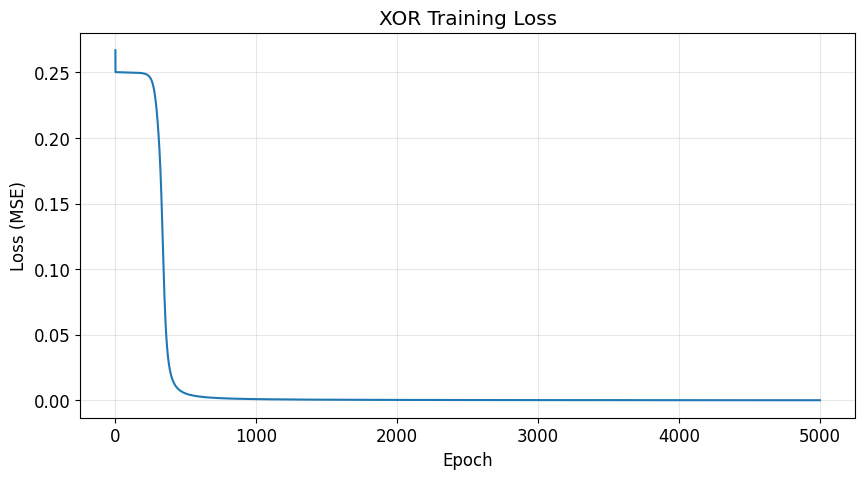


XOR Predictions:
--------------------------------------------------
Input: [0 0] -> Output: 0.0099 -> Rounded: 0 (Expected: 0) ✓
Input: [0 1] -> Output: 0.9879 -> Rounded: 1 (Expected: 1) ✓
Input: [1 0] -> Output: 0.9909 -> Rounded: 1 (Expected: 1) ✓
Input: [1 1] -> Output: 0.0102 -> Rounded: 0 (Expected: 0) ✓


In [3]:
# Define XOR data
X_xor = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])

y_xor = np.array([[0],
                  [1],
                  [1],
                  [0]])

np.random.seed(42)
mlp_xor = MLP(n_inputs=2, n_hidden=4, n_outputs=1, learning_rate=2.0)
losses_xor = mlp_xor.train(X_xor, y_xor, epochs=5000, verbose=False)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses_xor)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('XOR Training Loss')
plt.grid(True, alpha=0.3)
plt.show()
# Test predictions
print("\nXOR Predictions:")
print("-" * 50)

for i in range(len(X_xor)):
    output = mlp_xor.forward(X_xor[i:i+1])
    rounded = round(output[0][0])
    correct = "✓" if rounded == y_xor[i][0] else "✗"
    print(f"Input: {X_xor[i]} -> Output: {output[0][0]:.4f} -> Rounded: {rounded} (Expected: {y_xor[i][0]}) {correct}")

## Exercise 3: Load and Prepare the Iris Dataset
The Iris dataset contains 150 samples of iris flowers with:
- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: Setosa, Versicolor, Virginica

### Task 3.1: Load and Explore the Data

In [4]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
print("Iris Dataset Overview")
print("=" * 50)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {iris.feature_names}")
print(f"Target names: {iris.target_names}")
print(f"\nClass distribution: {np.bincount(y)}")

Iris Dataset Overview
Features shape: (150, 4)
Target shape: (150,)

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

Class distribution: [50 50 50]


### Task 3.2: Normalise the Data
Normalise features to [0, 1] range for better neural network performance.

In [5]:
# Normalise features to [0, 1]
scaler = MinMaxScaler()
X_normalised = scaler.fit_transform(X)
print("Data Normalisation")
print("=" * 50)
print("Before normalisation:")
print(f"  Min: {X.min(axis=0)}")
print(f"  Max: {X.max(axis=0)}")
print("\nAfter normalisation:")
print(f"  Min: {X_normalised.min(axis=0)}")
print(f"  Max: {X_normalised.max(axis=0)}")

Data Normalisation
Before normalisation:
  Min: [4.3 2.  1.  0.1]
  Max: [7.9 4.4 6.9 2.5]

After normalisation:
  Min: [0. 0. 0. 0.]
  Max: [1. 1. 1. 1.]


### Task 3.3: One-Hot Encode the Targets
For multi-class classification with neural networks, we convert class labels to one-hot encoding:
- Class 0 → [1, 0, 0]
- Class 1 → [0, 1, 0]
- Class 2 → [0, 0, 1]

In [6]:
# One-hot encode targets
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))
print("One-Hot Encoding")
print("=" * 50)
print(f"Original y[:5]: {y[:5]}")
print(f"\nOne-hot y[:5]:")
print(y_onehot[:5])
print(f"\nEncoding: 0 → [1,0,0], 1 → [0,1,0], 2 → [0,0,1]")

One-Hot Encoding
Original y[:5]: [0 0 0 0 0]

One-hot y[:5]:
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

Encoding: 0 → [1,0,0], 1 → [0,1,0], 2 → [0,0,1]


### Task 3.4: Split into Training and Test Sets

In [7]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_normalised, y_onehot, test_size=0.2, random_state=42, stratify=y
)
# Also keep original labels for evaluation
_, _, y_train_labels, y_test_labels = train_test_split(
    X_normalised, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test Split")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train/Test Split
Training set: 120 samples
Test set: 30 samples


## Exercise 4: Train the MLP on Iris
### Task 4.1: Create and Train the Network
**Suggested architecture:**
- 4 input neurons (one per feature)
- 8 hidden neurons
- 3 output neurons (one per class)

In [8]:
np.random.seed(42)

print("Training MLP on Iris dataset...")
print("=" * 50)
mlp_iris = MLP(n_inputs=4, n_hidden=8, n_outputs=3, learning_rate=0.5)

# Train
losses_iris = mlp_iris.train(X_train, y_train, epochs=1000, verbose=True)

Training MLP on Iris dataset...
Epoch 0: Loss = 0.245520
Epoch 100: Loss = 0.176187
Epoch 200: Loss = 0.027995
Epoch 300: Loss = 0.012206
Epoch 400: Loss = 0.010660
Epoch 500: Loss = 0.018713
Epoch 600: Loss = 0.016211
Epoch 700: Loss = 0.008597
Epoch 800: Loss = 0.009899
Epoch 900: Loss = 0.009375
Epoch 999: Loss = 0.010350


### Task 4.2: Plot Training Loss
Visualise how the loss decreases during training.

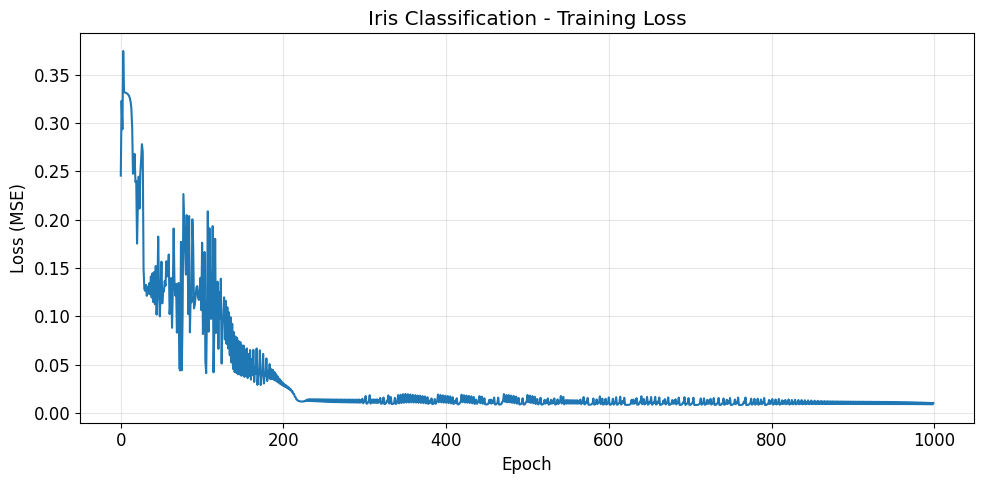

Figure saved as 'iris_training_loss.png'


In [9]:
plt.figure(figsize=(10, 5))
plt.plot(losses_iris)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Iris Classification - Training Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('iris_training_loss.png', dpi=150)
plt.show()
print("Figure saved as 'iris_training_loss.png'")

### Task 4.3: Evaluate on Test Set

In [10]:
# Predictions
y_pred = mlp_iris.predict(X_test)
y_true = np.argmax(y_test, axis=1)
# Accuracy
accuracy = np.mean(y_pred == y_true)
print("Test Set Evaluation")
print("=" * 50)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Correct predictions: {np.sum(y_pred == y_true)}/{len(y_true)}")

Test Set Evaluation
Test Accuracy: 93.33%
Correct predictions: 28/30


## Exercise 5: Confusion Matrix (From Scratch)
A confusion matrix shows the counts of correct and incorrect predictions for each class.
For a binary classifier:

|   | Predicted + | Predicted - |
|---|-------------|-------------|
| Actual + | TP | FN |
| Actual - | FP | TN |

### Task 5.1: Implement Confusion Matrix

In [11]:
def compute_confusion_matrix(y_true, y_pred, n_classes):
    """
    Compute confusion matrix from scratch.
    
    Parameters:
    ----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    n_classes : int
        Number of classes
        
    Returns:
    -------
    ndarray : Confusion matrix of shape (n_classes, n_classes)
    """
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    
    return cm

# Compute confusion matrix
cm = compute_confusion_matrix(y_true, y_pred, n_classes=3)

print("Confusion Matrix (from scratch)")
print("=" * 50)
print(cm)
print(f"\nRows = Actual, Columns = Predicted")
print(f"Diagonal = Correct predictions")

Confusion Matrix (from scratch)
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]

Rows = Actual, Columns = Predicted
Diagonal = Correct predictions


### Task 5.2: Verify with sklearn
Compare your from-scratch implementation with sklearn's built-in function.

In [12]:
from sklearn.metrics import confusion_matrix as sklearn_cm, classification_report

# sklearn's confusion matrix (should match ours)
cm_sklearn = sklearn_cm(y_true, y_pred)

print("Verification with sklearn")
print("=" * 50)
print("Our confusion matrix:")
print(cm)
print("\nsklearn confusion matrix:")
print(cm_sklearn)
print(f"\nMatrices match: {np.array_equal(cm, cm_sklearn)}")

# Full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=iris.target_names))

Verification with sklearn
Our confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]

sklearn confusion matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  2  8]]

Matrices match: True

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



### Task 5.3: Visualise the Confusion Matrix

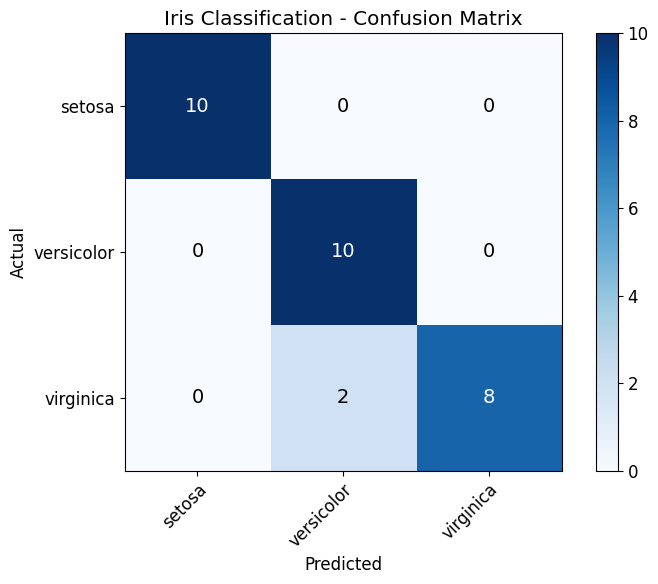

Figure saved as 'iris_confusion_matrix.png'


In [13]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    Plot confusion matrix as a heatmap.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')
    
    # Rotate tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=14)
    
    plt.tight_layout()
    return fig

# Plot
fig = plot_confusion_matrix(cm, iris.target_names, "Iris Classification - Confusion Matrix")
plt.savefig('iris_confusion_matrix.png', dpi=150)
plt.show()
print("Figure saved as 'iris_confusion_matrix.png'")

### Task 5.4: Compute Performance Metrics
From the confusion matrix, compute:
- **Accuracy** = (TP + TN) / Total
- **Precision** (per class) = TP / (TP + FP)
- **Recall / Sensitivity** (per class) = TP / (TP + FN)

In [14]:
def compute_metrics(cm):
    
    """Compute accuracy, precision, and recall from confusion matrix."""
    n_classes = cm.shape[0]
    
    # Accuracy: sum of diagonal / total
    accuracy = np.trace(cm) / np.sum(cm)
    
    # Per-class precision and recall
    precision = np.zeros(n_classes)
    recall = np.zeros(n_classes)
    
    for i in range(n_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp  # Column sum minus TP
        fn = np.sum(cm[i, :]) - tp  # Row sum minus TP
        
        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return accuracy, precision, recall

# Compute metrics
accuracy, precision, recall = compute_metrics(cm)

print("Performance Metrics")
print("=" * 50)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"\nPer-class metrics:")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12}")
print("-" * 39)
for i, name in enumerate(iris.target_names):
    print(f"{name:<15} {precision[i]*100:>8.2f}%    {recall[i]*100:>8.2f}%")

Performance Metrics
Overall Accuracy: 93.33%

Per-class metrics:
Class           Precision    Recall      
---------------------------------------
setosa            100.00%      100.00%
versicolor         83.33%      100.00%
virginica         100.00%       80.00%


## Exercise 6: Compare with sklearn's MLPClassifier
Verify your implementation by comparing with sklearn's built-in MLP.

**Note:** sklearn's MLPClassifier typically achieves higher accuracy because it includes:
- Better weight initialisation (Xavier/Glorot)
- Momentum to smooth gradient updates
- Adaptive learning rate
- L2 regularisation
- Softmax output with cross-entropy loss (optimal for classification)

Our simpler implementation demonstrates the core concepts but lacks these optimisations.
sklearn also handles one-hot encoding internally when you pass class labels.

In [15]:
# sklearn MLP
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(8,),      # One hidden layer with 8 neurons
    activation='logistic',         # Sigmoid activation
    solver='sgd',                  # Stochastic gradient descent
    learning_rate_init=0.5,
    max_iter=1000,
    random_state=42
)
# Train (sklearn receives class labels, not one-hot)
sklearn_mlp.fit(X_train, y_train_labels)
# Evaluate
sklearn_pred = sklearn_mlp.predict(X_test)
sklearn_accuracy = accuracy_score(y_test_labels, sklearn_pred)
print("Comparison: Our MLP vs sklearn MLPClassifier")
print("=" * 50)
print(f"Our MLP Accuracy:     {accuracy * 100:.2f}%")
print(f"sklearn MLP Accuracy: {sklearn_accuracy * 100:.2f}%")
print(f"\nsklearn typically achieves higher accuracy due to its optimisations.")

Comparison: Our MLP vs sklearn MLPClassifier
Our MLP Accuracy:     93.33%
sklearn MLP Accuracy: 96.67%

sklearn typically achieves higher accuracy due to its optimisations.


## Exercise 7: Cross-Validation
Use 10-fold cross-validation to get a more robust estimate of model performance.

10-Fold Cross-Validation Results
Fold scores: [1.         1.         1.         0.93333333 0.93333333 1.
 0.86666667 1.         1.         1.        ]

Mean accuracy: 97.33%
Standard deviation: 4.42%

95% confidence interval: 97.33% ± 8.67%


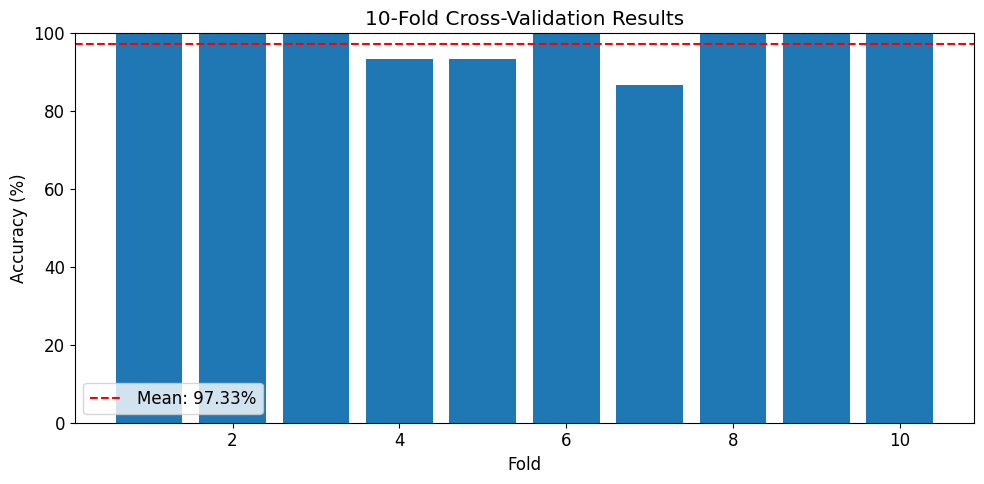

In [16]:
# Create sklearn MLP for cross-validation
sklearn_mlp_cv = MLPClassifier(
    hidden_layer_sizes=(8,),
    activation='logistic',
    solver='sgd',
    learning_rate_init=0.5,
    max_iter=1000,
    random_state=42
)

# 10-fold cross-validation
cv_scores = cross_val_score(sklearn_mlp_cv, X_normalised, y, cv=10)

print("10-Fold Cross-Validation Results")
print("=" * 50)
print(f"Fold scores: {cv_scores}")
print(f"\nMean accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard deviation: {cv_scores.std() * 100:.2f}%")
print(f"\n95% confidence interval: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100*1.96:.2f}%")
      
# Visualise
plt.figure(figsize=(10, 5))
plt.bar(range(1, 11), cv_scores * 100)
plt.axhline(y=cv_scores.mean() * 100, color='r', linestyle='--', label=f'Mean: {cv_scores.mean()*100:.2f}%')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.title('10-Fold Cross-Validation Results')
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()